In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
# Defining some constant.
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [7]:
# Loading images data with the help of Dataset API.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset", 
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
# Storing class names.
class_names = dataset.class_names

In [11]:
# Explore the dataset.
# Taking 1 batch of 32 images to explore.
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 2 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 2 0 0 1 1 1 0 0 1]


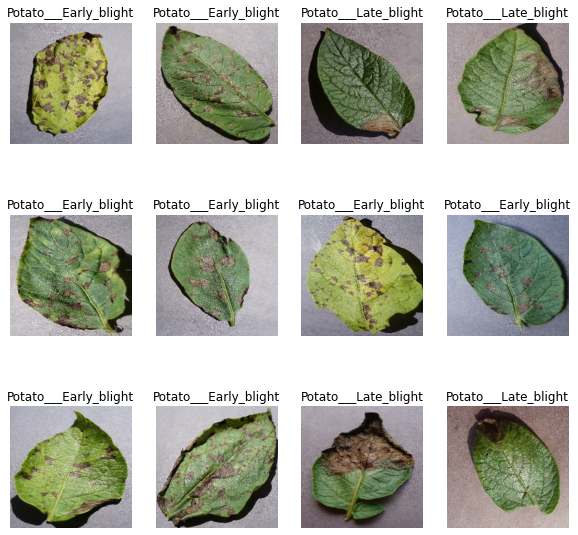

In [20]:
# Data visualization.
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [27]:
# Splitting training set, testing set and validation set.
# Training Set = 80%
# Validation Set = 10%
# Test Set = 10%
# """80% is our training dataset, Ok we'll take the first 80% of the data images for training. Following is how we split ttrainig data."""
# # First we will describe th  train size in 0 to 1. Then counts the len(dataset)*train size, it will provide us the number of images we have to take for training_data.

# # train_size = 0.8
# # len(dataset)*train_size
# training_dataset = dataset.take(54)

# """10% is our testing dataset, Ok we'll skip rest after training data. It will give us the another 20% images."""
# testing_dataset = dataset.skip(54)

# """10% is our validation data, Ok we'll take the half len(testing_data)*0.1[validation_size]. It will splits the testing and validation data to 0.1(10%)"""
# validation_dataset = testing_dataset.take(7)

In [42]:
def get_dataset_partitions_tf(dataset, train_split=0.8, validation_split=0.1, testing_split=0.1, shuffle=True, shuffle_size=10000):
    # Asserting just because user/developer cannot split data with wrong points of spliting.
    assert (train_split + validation_split + testing_split) == 1

    # Dataset size.
    dataset_size = len(dataset)

    # Shuffling the data.
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    # Acutal splitting the dataset.shuffle
    training_size = int(train_split*dataset_size)
    validation_size = int(validation_split*dataset_size)
    testing_size = int(testing_split*dataset_size)

    training_dataset = dataset.take(training_size)
    validation_dataset = dataset.skip(training_size).take(validation_size)
    testing_dataset = dataset.skip(training_size).skip(validation_size)

    return training_dataset, validation_dataset, testing_dataset

In [43]:
training_dataset, validation_dataset, testing_dataset = get_dataset_partitions_tf(dataset)

In [45]:
# Just checking that dataset is properly splitted or not!
print("Training Length : ", len(training_dataset))
print("Validation Length : ", len(validation_dataset))
print("Testing Length : ", len(testing_dataset))

Training Length :  54
Validation Length :  6
Testing Length :  8


In [49]:
# Data Augmentation part starts from here..
# cache() = We use cache() because when we train the model insteading of putting data into a disk it will put data into a RAM (Memory). It will Increase the training speed.
# shuffle() = Shuffle will randmly arrange the data. It's a good idea to generate randomness in dataset for training.
# prefetch() = Also used for performance tuning.
training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [50]:
# Rescaling and Resizing.
# Why we resizing the image? ==> Because if we take picture a leaf after a deployment. It not neccessary that picture is fixed size of 256X256, therefore we resize the image ti 256X256.
# Why we resclaling the image? ==? Becasue Images are going to convert into a numpy array. Number of Images in numpy array is from 0 to 255. We normalize them into 0 to 1. It will increase the training time.
resize_and_rescale = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [51]:
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2)
])